In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split ### helps to split the data into train and val
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [2]:
weather_data = pd.read_csv('Data_archive/weather_prediction_dataset.csv')
pred_data = pd.read_csv('Data_archive/weather_prediction_bbq_labels.csv')
weather_data

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,20091229,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,20091230,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,20091231,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9


In [3]:
merged_data = pd.merge(weather_data, pred_data, on='DATE')
merged_data.isna().sum().sum()

oslo_columns = merged_data.filter(like='OSLO')
X = pd.concat([merged_data[['DATE', 'MONTH']], merged_data[oslo_columns.columns]], axis=1)
Y = merged_data['OSLO_BBQ_weather']

In [4]:
Y = Y.astype(int)
Y

0       0
1       0
2       0
3       0
4       0
       ..
3649    0
3650    0
3651    0
3652    0
3653    0
Name: OSLO_BBQ_weather, Length: 3654, dtype: int32

In [5]:
# Calculate Pearson correlation coefficients
correlations = X.corrwith(Y)

# Absolute values of correlations for better interpretation
correlations = correlations.abs()

# Sort correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

OSLO_BBQ_weather         1.000000
OSLO_global_radiation    0.606420
OSLO_temp_max            0.588684
OSLO_temp_mean           0.560277
OSLO_sunshine            0.512060
OSLO_temp_min            0.473198
OSLO_humidity            0.436719
OSLO_cloud_cover         0.302656
OSLO_precipitation       0.210962
OSLO_pressure            0.162005
MONTH                    0.053296
OSLO_wind_gust           0.034094
OSLO_wind_speed          0.029494
DATE                     0.012782
dtype: float64


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

params_grid = {
    "n_estimators":[500],
    "max_depth": [8,11,13,None],
    "min_samples_split":[50, 75, 100],
    "max_features":["sqrt", 0.5],
    "n_jobs": [-1],
    "class_weight": [{0:1,1:3}, {0:1, 1:4}, {0:0.9, 1:3.5}, {0:1.2, 1:4.2}]
}

grid_search_cv = GridSearchCV(
    estimator=rf,
    param_grid=params_grid,
    scoring='f1',
    cv=5,
    return_train_score=True
)

clf = grid_search_cv.fit(X_train, y_train)

In [15]:
print(clf.best_params_)
print(clf.best_score_)

{'class_weight': {0: 1, 1: 3}, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 500, 'n_jobs': -1}
1.0


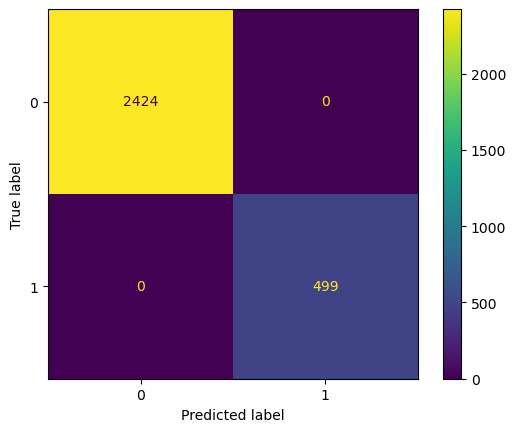

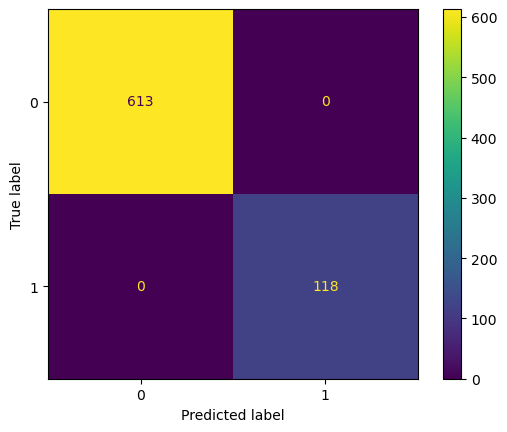

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

tr_pred = clf.predict(X_train)
val_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_train, tr_pred)
ConfusionMatrixDisplay.from_predictions(y_test, val_pred)